# Imports

In [5]:
from configuration.paths import *

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers

from src.datasets.chest_xray import ChestXRay
from src.utils.schemes import Scheme
from src.utils.image import Image

# Dataset loading for training

In [6]:
IMAGE_SIZE = (256, 256)

In [7]:
cx = ChestXRay(DATASET_CHEST_XRAY_PATH, IMAGE_SIZE)

In [8]:
Scheme.dataset_info(cx)

Train:
 - Normal: 1341
 - Pneumonia: 1938
Test:
 - Normal: 234
 - Pneumonia: 390
Val:
 - Normal: 8
 - Pneumonia: 8


In [9]:
x_train, y_train, _ = cx.load_train_data()
x_train = x_train / 255.0

x_val, y_val, _ = cx.load_val_data()
x_val = x_val / 255.0

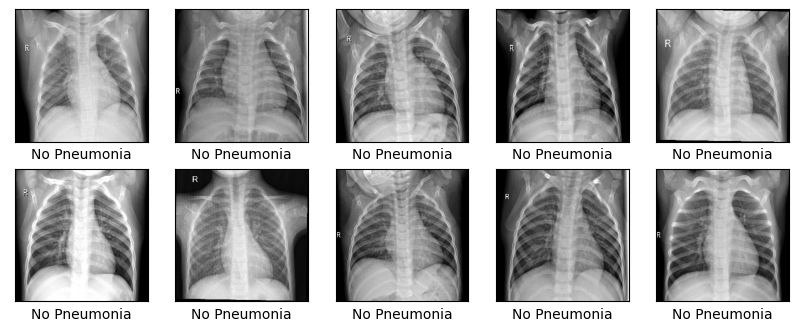

In [10]:
Scheme.labeled_images(x_train, y_train)

# Mdel definition

In [11]:
model = models.Sequential()

model.add(layers.Conv2D(filters=8, activation='relu', kernel_size=3, padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=16, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=32, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
Total params: 6,032
Trainable params: 6,032
Non-trainable params: 0
______________________________________________________

In [12]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

In [13]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])

# Model training

In [14]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=35)

Epoch 1/35
103/103 [==============================] - 6s 37ms/step - loss: 0.4440 - binary_accuracy: 0.7692 - precision: 0.7916 - recall: 0.8266 - val_loss: 0.3116 - val_binary_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 2/35
103/103 [==============================] - 3s 28ms/step - loss: 0.1362 - binary_accuracy: 0.9464 - precision: 0.9541 - recall: 0.9524 - val_loss: 0.2711 - val_binary_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 3/35
103/103 [==============================] - 3s 28ms/step - loss: 0.1210 - binary_accuracy: 0.9533 - precision: 0.9675 - recall: 0.9537 - val_loss: 0.3198 - val_binary_accuracy: 0.6875 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 4/35
103/103 [==============================] - 3s 28ms/step - loss: 0.0947 - binary_accuracy: 0.9667 - precision: 0.9730 - recall: 0.9702 - val_loss: 0.6933 - val_binary_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/35
103/103 [========================

<Figure size 640x480 with 0 Axes>

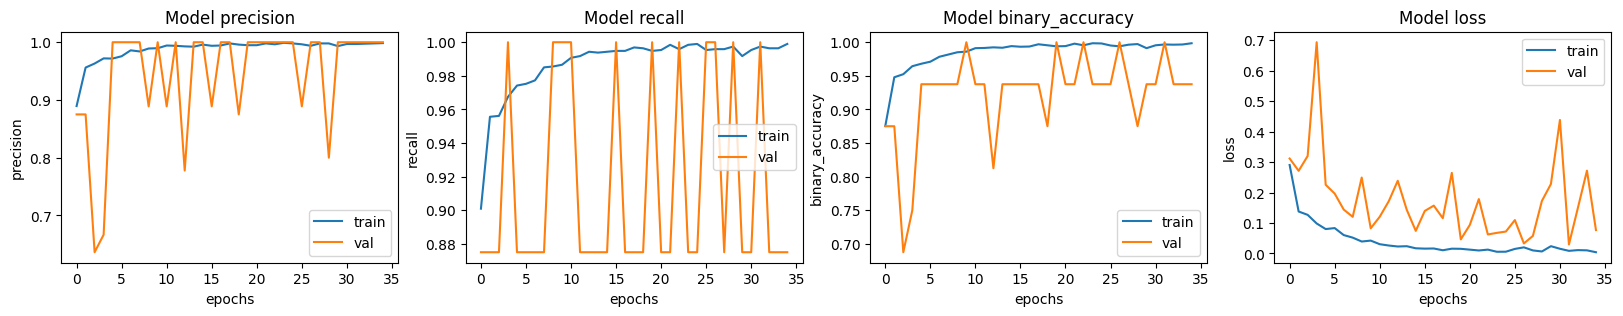

In [15]:
Scheme.training_graphs(history)

In [16]:
del x_train
del y_train

# Evaluating the model

In [17]:
x_test, y_test, diagnosis = cx.load_test_data()
x_test = x_test / 255.0

In [20]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 9ms/step - loss: 3.1175 - binary_accuracy: 0.7628 - precision: 0.7266 - recall: 0.9949


In [ ]:
images = [x_test[10], x_test[11], x_test[55], x_test[67], x_test[60],
          x_test[202], x_test[203], x_test[206], x_test[217], x_test[220]]
labels = [1, 1, 1, 1, 1,
          0, 0, 0, 0, 0]
images = Image.explainer(images, model, IMAGE_SIZE)

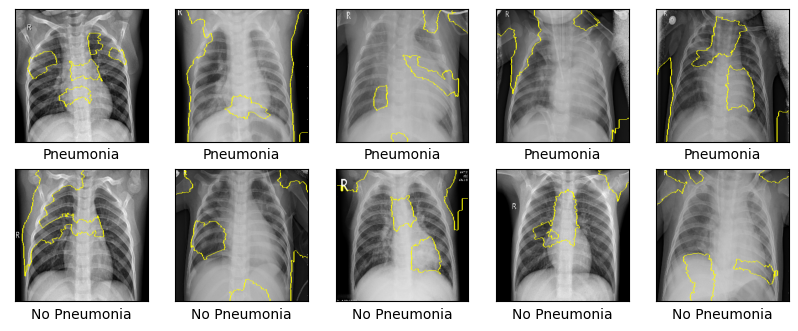

In [19]:
Scheme.labeled_images(images, labels)

In [21]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

<Figure size 640x480 with 0 Axes>

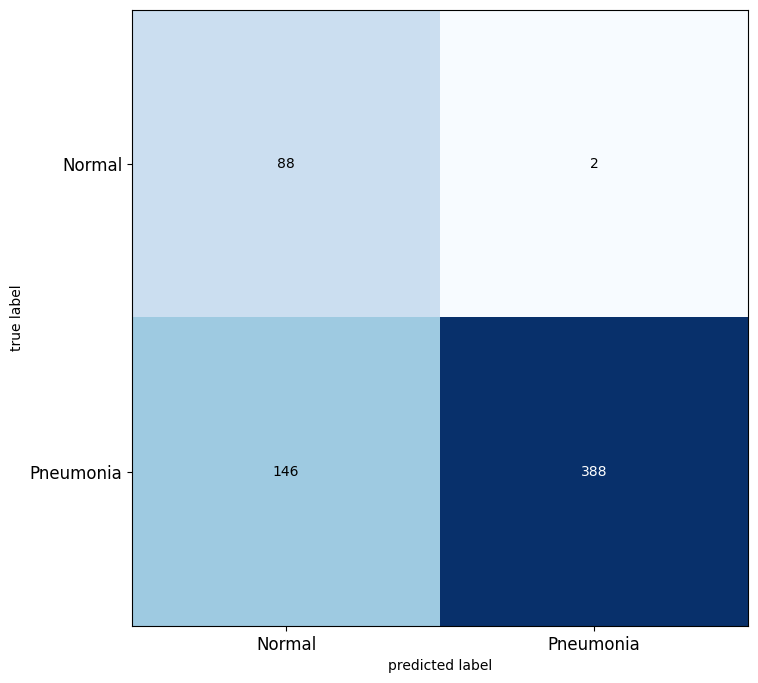

In [22]:
Scheme.confusion_matrix(predictions_rounded, cx.get_test_df().diagnosis.to_numpy())